In [ ]:
try:
    import cv2
    import mediapipe as mp
    from mediapipe.tasks import python
    from mediapipe.tasks.python import vision
    from mediapipe import solutions
    from mediapipe.framework.formats import landmark_pb2
except:
    %pip install opencv-python-headless==4.9.0.80
    %pip install mediapipe

import cv2, sys, os, math
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from tqdm import tqdm
from typing import Tuple, Union
import pandas as pd

# mediapipe
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2

print('import succesful')

In [ ]:
MARGIN = 10  # pixels
ROW_SIZE = 10  # pixels
FONT_SIZE = 1
FONT_THICKNESS = 1
TEXT_COLOR = (255, 0, 0)  # red


def _normalized_to_pixel_coordinates(normalized_x: float, 
                                     normalized_y: float, 
                                     image_width: int,
                                     image_height: int) -> Union[None, Tuple[int, int]]:
  """Converts normalized value pair to pixel coordinates."""

  # Checks if the float value is between 0 and 1.
  def is_valid_normalized_value(value: float) -> bool:
    return (value > 0 or math.isclose(0, value)) and (value < 1 or math.isclose(1, value))

  if not (is_valid_normalized_value(normalized_x) and is_valid_normalized_value(normalized_y)):
    return None

  x_px = min(math.floor(normalized_x * image_width), image_width - 1)
  y_px = min(math.floor(normalized_y * image_height), image_height - 1)
  return x_px, y_px


def visualize(image, detection_result) -> np.ndarray:
  """Draws bounding boxes and keypoints on the input image and return it.
  Args:
    image: The input RGB image.
    detection_result: The list of all "Detection" entities to be visualize.
  Returns:
    Image with bounding boxes.
  """
  annotated_image = image.copy()
  height, width, _ = image.shape

  for detection in detection_result.detections:
    # Draw bounding_box
    bbox = detection.bounding_box
    start_point = bbox.origin_x, bbox.origin_y
    end_point = bbox.origin_x + bbox.width, bbox.origin_y + bbox.height
    cv2.rectangle(annotated_image, start_point, end_point, TEXT_COLOR, 3)

    # Draw keypoints
    for keypoint in detection.keypoints:
      keypoint_px = _normalized_to_pixel_coordinates(keypoint.x, keypoint.y,
                                                     width, height)
      color, thickness, radius = (0, 255, 0), 2, 2
      cv2.circle(annotated_image, keypoint_px, thickness, color, radius)

    # Draw label and score
    category = detection.categories[0]
    category_name = category.category_name
    category_name = '' if category_name is None else category_name
    probability = round(category.score, 2)
    result_text = category_name + ' (' + str(probability) + ')'
    text_location = (MARGIN + bbox.origin_x, 
                     MARGIN + ROW_SIZE + bbox.origin_y)
    cv2.putText(annotated_image, result_text, text_location, cv2.FONT_HERSHEY_PLAIN,
                FONT_SIZE, TEXT_COLOR, FONT_THICKNESS)

  return annotated_image

In [ ]:
def draw_landmarks_on_image(rgb_image, detection_result):
  face_landmarks_list = detection_result.face_landmarks
  annotated_image = np.copy(rgb_image)

  # Loop through the detected faces to visualize.
  for idx in range(len(face_landmarks_list)):
    face_landmarks = face_landmarks_list[idx]

    # Draw the face landmarks.
    face_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    face_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in face_landmarks
    ])

    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_TESSELATION,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp.solutions.drawing_styles
        .get_default_face_mesh_tesselation_style())
    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_CONTOURS,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp.solutions.drawing_styles
        .get_default_face_mesh_contours_style())
    solutions.drawing_utils.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_IRISES,
          landmark_drawing_spec=None,
          connection_drawing_spec=mp.solutions.drawing_styles
          .get_default_face_mesh_iris_connections_style())

  return annotated_image

def plot_face_blendshapes_bar_graph(face_blendshapes):
  # Extract the face blendshapes category names and scores.
  face_blendshapes_names = [face_blendshapes_category.category_name for face_blendshapes_category in face_blendshapes]
  face_blendshapes_scores = [face_blendshapes_category.score for face_blendshapes_category in face_blendshapes]
  # The blendshapes are ordered in decreasing score value.
  face_blendshapes_ranks = range(len(face_blendshapes_names))

  fig, ax = plt.subplots(figsize=(12, 12))
  bar = ax.barh(face_blendshapes_ranks, face_blendshapes_scores, label=[str(x) for x in face_blendshapes_ranks])
  ax.set_yticks(face_blendshapes_ranks, face_blendshapes_names)
  ax.invert_yaxis()

  # Label each bar with values
  for score, patch in zip(face_blendshapes_scores, bar.patches):
    plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{score:.4f}", va="top")

  ax.set_xlabel('Score')
  ax.set_title('Face Blendshapes')
  plt.tight_layout()
  plt.show()

# extract landmarks to csv
def extract_and_save_landmarks(c_df, img_cv2, idx):
    rgb_frame = mp.Image(image_format=mp.ImageFormat.SRGB, data=img_cv2)
    detection_result = detector_mesh.detect(rgb_frame)
    df = pd.DataFrame([(idx, p.name, index, point.x, point.y, point.z) for index, point in enumerate(detection_result.face_landmarks[0])], columns=['image_idx', 'image_name', 'landmark_idx', 'x', 'y', 'z'])
    c_df = c_df.append(df)
    return c_df

In [ ]:
def save_image(path, img):
    cv2.imwrite(path, img)

def show_image(img):
    plt.imshow(img, cmap='gray')
    plt.show()

def read_cv2_image(image_path):
    return cv2.imread(str(image_path))

def read_mp_cv2_image(image_path):
    return mp.Image.create_from_file(str(image_path)), cv2.imread(str(image_path))

# convert png to jpg
def png_to_jpg(image_path):
    img = cv2.imread(str(image_path))
    jpg_path = str(image_path.with_suffix('.jpg'))
    cv2.imwrite(jpg_path, img, [int(cv2.IMWRITE_JPEG_QUALITY), 100])
    image_path.unlink()

# rename JPG
def rename_jpg_files(image_path):
    image_path = Path(image_path)
    new_path = image_path.with_suffix('.jpg')
    image_path.rename(new_path)

# mediapipe face detection & cropping 
def crop_faces(img_cv2, detection_results, out_path):
    for d in detection_results.detections:  
        bbox = d.bounding_box
        origin_x, origin_y, width, height = bbox.origin_x, bbox.origin_y, bbox.width, bbox.height
        cropped_img = img_cv2[origin_y:origin_y+height, origin_x:origin_x+width]
        #show_image(cropped_img)      
        cv2.imwrite(str(out_path), cropped_img)
        return cropped_img

In [ ]:
PATH = Path('/home/jovyan/work/output/frames')
IMAGES = list(PATH.rglob('*.jpg'))

In [ ]:
model_path_detect = '/home/jovyan/work/models/blaze_face_short_range.tflite'
model_path_mesh = '/home/jovyan/work/models/face_landmarker.task'

base_options_detect = python.BaseOptions(model_asset_path=model_path_detect)
options_detect = vision.FaceDetectorOptions(base_options=base_options_detect)
detector_detect = vision.FaceDetector.create_from_options(options_detect)

base_options_mesh = python.BaseOptions(model_asset_path=model_path_mesh)
options_mesh = vision.FaceLandmarkerOptions(base_options=base_options_mesh,
                                       output_face_blendshapes=False,
                                       output_facial_transformation_matrixes=True,
                                       num_faces=1)
detector_mesh = vision.FaceLandmarker.create_from_options(options_mesh)

In [ ]:
print(IMAGES[0])

In [ ]:
path = (IMAGES[0])

img_mp, img_cv2 = read_mp_cv2_image(path)

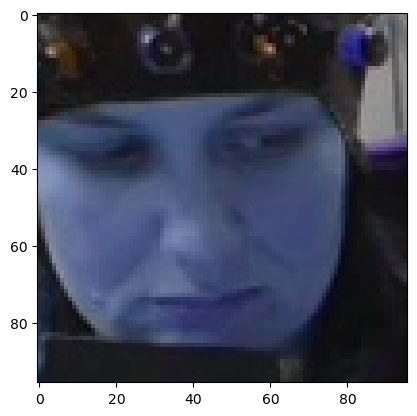

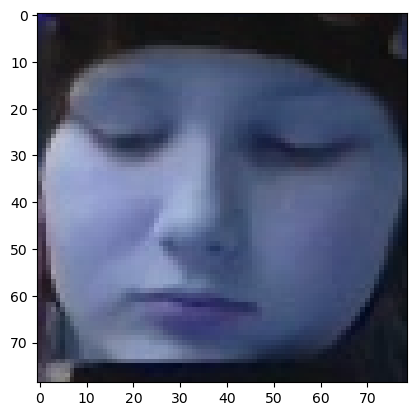

In [33]:


# face detection & crop
detection_results = detector_detect.detect(img_mp)

d1 = detection_results.detections[0]
d2 = detection_results.detections[1]

bbox = d1.bounding_box
origin_x, origin_y, width, height = bbox.origin_x, bbox.origin_y, bbox.width, bbox.height
cropped_img = img_cv2[origin_y:origin_y+height, origin_x:origin_x+width]
show_image(cropped_img)  

cv2.imwrite('/home/jovyan/work/img.jpg', cropped_img)


bbox = d2.bounding_box
origin_x, origin_y, width, height = bbox.origin_x, bbox.origin_y, bbox.width, bbox.height
cropped_img = img_cv2[origin_y:origin_y+height, origin_x:origin_x+width]
show_image(cropped_img)  


In [36]:
path = '/home/jovyan/work/img.jpg'

img_mp, img_cv2 = read_mp_cv2_image(path)

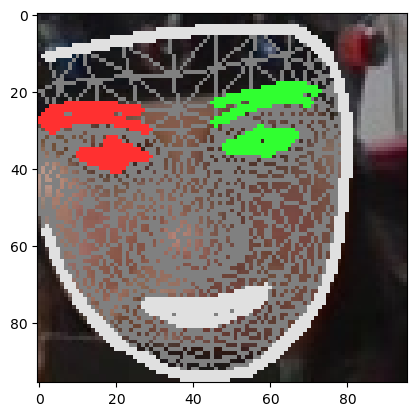

In [37]:
# face mesh
rgb_frame = mp.Image(image_format=mp.ImageFormat.SRGB, data=img_cv2)
mesh_results = detector_mesh.detect(rgb_frame)
annotated_image = draw_landmarks_on_image(rgb_frame.numpy_view(), mesh_results)
res_img = cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR)
show_image(res_img)

In [ ]:

for d in detection_results.detections:  
    bbox = d.bounding_box
    origin_x, origin_y, width, height = bbox.origin_x, bbox.origin_y, bbox.width, bbox.height
    cropped_img = img_cv2[origin_y:origin_y+height, origin_x:origin_x+width]
    #show_image(cropped_img)      
    cv2.imwrite(str(out_path), cropped_img)


cropped_img = crop_faces(img_cv2, detection_results, '/home/jovyan/work/cropped.jpg')
show_image(cropped_img)

# face mesh
rgb_frame = mp.Image(image_format=mp.ImageFormat.SRGB, data=img_cv2)
detection_result = detector_mesh.detect(rgb_frame)
annotated_image = draw_landmarks_on_image(rgb_frame.numpy_view(), detection_result)
res_img = cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR)
show_image(res_img)